In [1]:
from datasets import PaderbornDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from adapt.feature_based import DANN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from adapt.feature_based import CORAL
import torch
import torch.nn as nn

In [2]:
paderborn_loader = PaderbornDataset(path='./data')

In [3]:
def get_domain(rpm):
    return paderborn_loader.load_data(
        fault_methods=['Artificial', 'Real', 'Healthy'],
        fault_types=['OR', 'IR'],
        rpm=rpm,
        torque=0.7,
        radial_force=1000
    )

In [4]:
data = get_domain(1500)
data_target = get_domain(900)

In [5]:
print("Структура загруженных данных:", data.keys())

Структура загруженных данных: dict_keys(['phase_current_1', 'phase_current_2', 'measurement', 'class', 'bearing_name'])


In [6]:
def raw_to_windows(dic):
    # 2.1 Формируем X (два канала тока) и y
    X = np.stack([dic['phase_current_1'],
                  dic['phase_current_2']], axis=-1)
    X = X.reshape(-1, 256_000, 2)
    y = dic['class'].reshape(-1, 256_000)[:,0]

    # 2.2 Добавляем 3-й канал = векторная сумма
    X3 = np.zeros((X.shape[0], X.shape[1], 3), dtype=X.dtype)
    X3[:,:,:2] = X
    X3[:,:,2]  = np.sqrt(X[:,:,0]**2 + X[:,:,1]**2)

    # 2.3 Скользящие окна
    win, step = 2000, 1000
    all_w, lab = [], []
    for sig, lab_i in zip(X3, y):
        view = np.lib.stride_tricks.sliding_window_view(sig, (win,3))
        all_w.append(view[::step,0])
        lab.append(np.full(len(view[::step]), lab_i))
    X_w   = np.concatenate(all_w)
    y_w   = np.concatenate(lab)

    # 2.4 Синхронизация фазой (по первому каналу)
    X_roll = np.empty_like(X_w)
    ref    = X_w[0,:,0]
    for i,row in enumerate(X_w):
        shift = np.argmax(np.correlate(ref,row[:,0],'full'))
        X_roll[i] = np.roll(row, shift, axis=0)
    return X_roll, y_w


In [7]:
# 3. Пре-обработка для обоих доменов
X_src_raw, y_src = raw_to_windows(data)
X_tgt_raw, y_tgt = raw_to_windows(data_target)

In [8]:
# 4. По source статистикам
mean_src = X_src_raw.mean((0,1))
std_src  = X_src_raw.std((0,1))

# используем source статистики
X_src_std = (X_src_raw - mean_src) / std_src
X_tgt_std = (X_tgt_raw - mean_src) / std_src  

print(f"Source - Mean: {X_src_std.mean():.6f}, Std: {X_src_std.std():.3f}")
print(f"Target - Mean: {X_tgt_std.mean():.3f}, Std: {X_tgt_std.std():.3f}")



Source - Mean: -0.000000, Std: 1.000
Target - Mean: -0.049, Std: 0.972



 АНАЛИЗ RAW ДАННЫХ:


/var/folders/t3/4qj_4k256mxg4l2py__407l00000gn/T/ipykernel_31368/3000471967.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([src_data, tgt_data], labels=['Source', 'Target'])


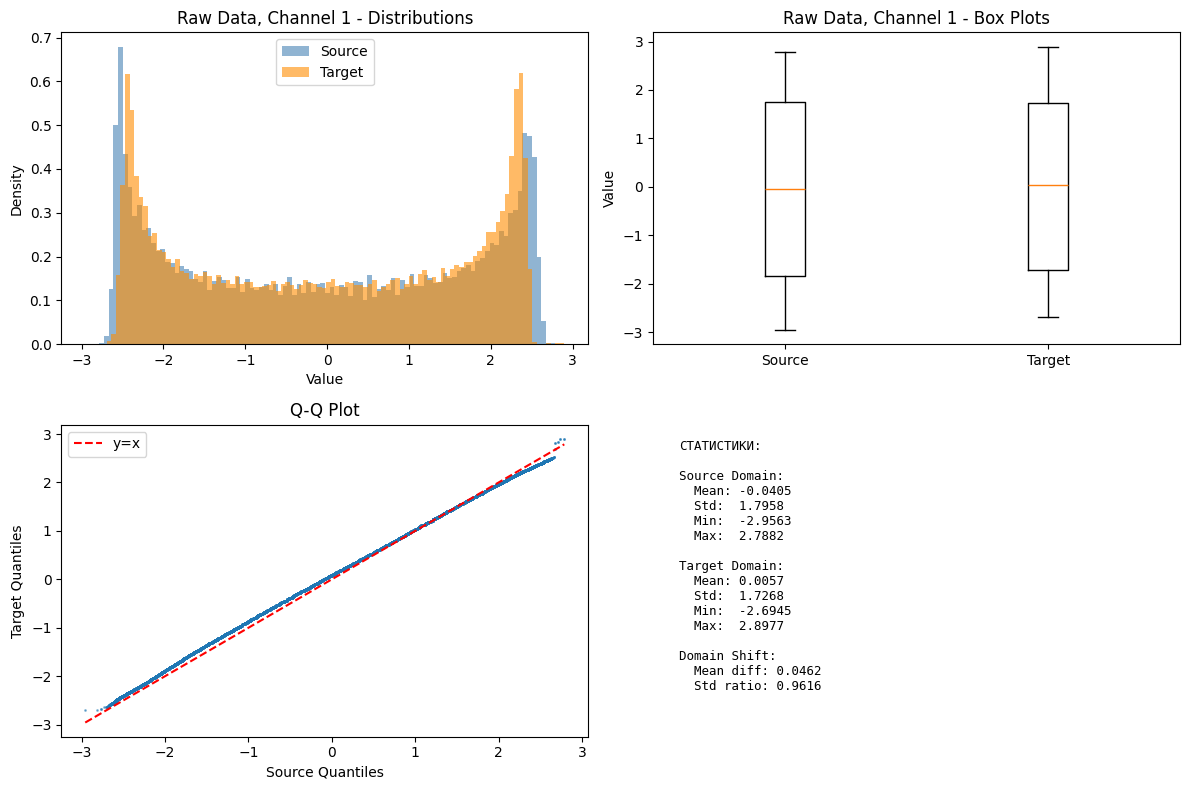


 АНАЛИЗ НОРМАЛИЗОВАННЫХ ДАННЫХ:


/var/folders/t3/4qj_4k256mxg4l2py__407l00000gn/T/ipykernel_31368/3000471967.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([src_data, tgt_data], labels=['Source', 'Target'])


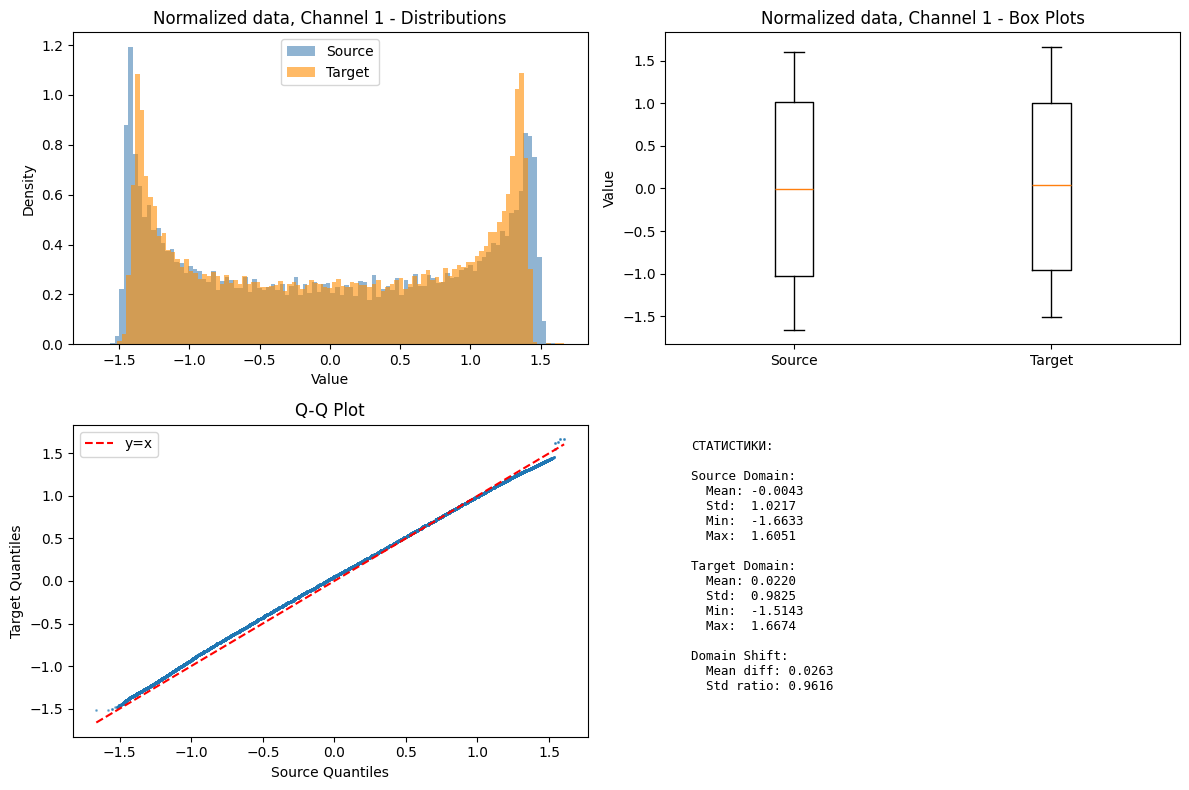

In [9]:
import matplotlib.pyplot as plt
def hist_compare_enhanced(src, tgt, title, channel=0):
    plt.figure(figsize=(12, 8))
    
    src_data = src[:, :, channel].flatten()[:20000]
    tgt_data = tgt[:, :, channel].flatten()[:20000]
    
    # Subplot 1: Гистограммы
    plt.subplot(2, 2, 1)
    plt.hist(src_data, 100, alpha=0.6, label='Source', color='steelblue', density=True)
    plt.hist(tgt_data, 100, alpha=0.6, label='Target', color='darkorange', density=True)
    plt.title(f'{title} - Distributions')
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Subplot 2: Box plots
    plt.subplot(2, 2, 2)
    plt.boxplot([src_data, tgt_data], labels=['Source', 'Target'])
    plt.title(f'{title} - Box Plots')
    plt.ylabel('Value')
    
    # Subplot 3: Q-Q plot для сравнения распределений
    plt.subplot(2, 2, 3)
    src_sorted = np.sort(src_data)
    tgt_sorted = np.sort(tgt_data)
    min_len = min(len(src_sorted), len(tgt_sorted))
    plt.scatter(src_sorted[:min_len], tgt_sorted[:min_len], alpha=0.5, s=1)
    plt.plot([src_sorted.min(), src_sorted.max()], 
             [src_sorted.min(), src_sorted.max()], 'r--', label='y=x')
    plt.xlabel('Source Quantiles')
    plt.ylabel('Target Quantiles')
    plt.title('Q-Q Plot')
    plt.legend()
    
    # Subplot 4: Статистики
    plt.subplot(2, 2, 4)
    stats_text = f"""СТАТИСТИКИ:

Source Domain:
  Mean: {src_data.mean():.4f}
  Std:  {src_data.std():.4f}
  Min:  {src_data.min():.4f}
  Max:  {src_data.max():.4f}

Target Domain:
  Mean: {tgt_data.mean():.4f}
  Std:  {tgt_data.std():.4f}
  Min:  {tgt_data.min():.4f}
  Max:  {tgt_data.max():.4f}

Domain Shift:
  Mean diff: {abs(src_data.mean() - tgt_data.mean()):.4f}
  Std ratio: {tgt_data.std() / src_data.std():.4f}
"""
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=9, verticalalignment='top', fontfamily='monospace')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Применяем к данным
print("\n АНАЛИЗ RAW ДАННЫХ:")
hist_compare_enhanced(X_src_raw, X_tgt_raw, 'Raw Data, Channel 1')

print("\n АНАЛИЗ НОРМАЛИЗОВАННЫХ ДАННЫХ:")
hist_compare_enhanced(X_src_std, X_tgt_std, 'Normalized data, Channel 1')


python(31615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


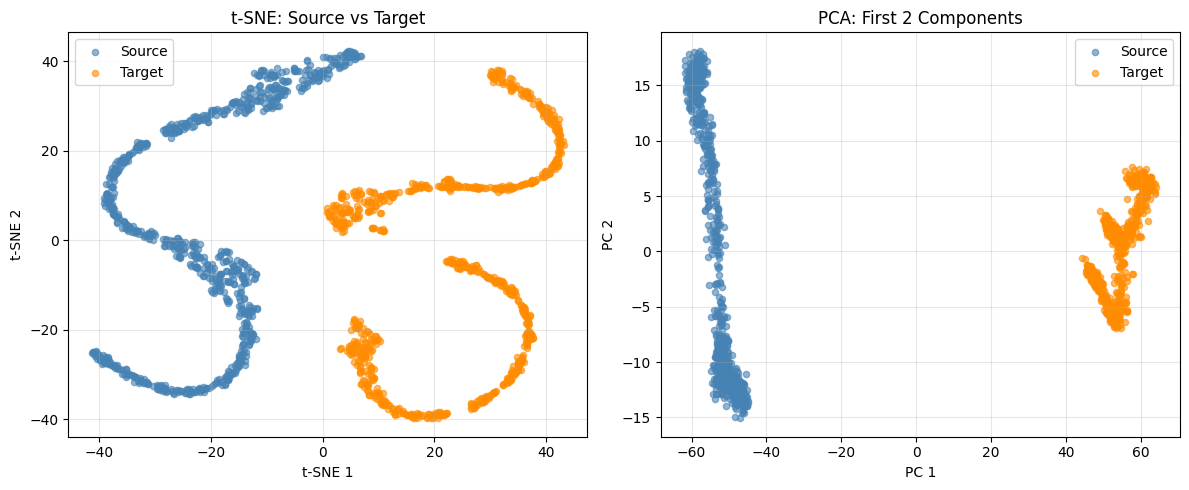

  Разделение доменов в пространстве t-SNE: 44.310
  PCA объяснение отношения дисперсии: 0.953


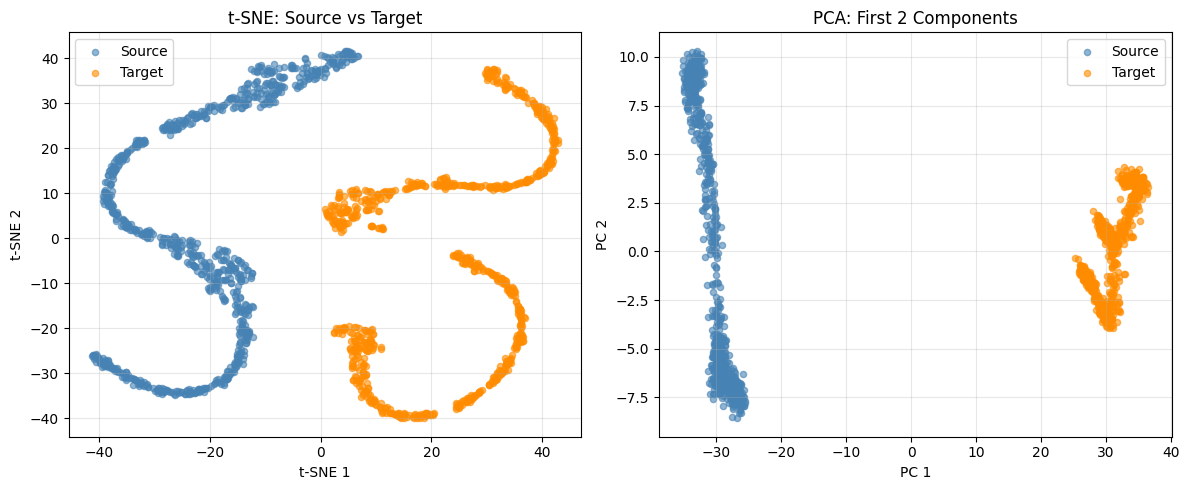

  Разделение доменов в пространстве t-SNE: 44.198
  PCA объяснение отношения дисперсии: 0.953


In [10]:
from sklearn.manifold import TSNE
# 7. Улучшенная t-SNE визуализация  
def compare_tsne_enhanced(src, tgt, channel=0, sample_size=1000):
    
    # Берем случайные окна для анализа
    np.random.seed(42)
    src_indices = np.random.choice(len(src), min(sample_size, len(src)), replace=False)
    tgt_indices = np.random.choice(len(tgt), min(sample_size, len(tgt)), replace=False)
    
    src_windows = src[src_indices, :, channel]  # [sample_size, 2000]
    tgt_windows = tgt[tgt_indices, :, channel]  # [sample_size, 2000]
    
    # Объединяем для t-SNE
    combined = np.vstack([src_windows, tgt_windows])
    
    # Уменьшаем размерность сначала PCA, потом t-SNE
    from sklearn.decomposition import PCA
    pca = PCA(n_components=50, random_state=42)
    combined_pca = pca.fit_transform(combined)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(combined_pca)
    
    # Визуализация
    plt.figure(figsize=(12, 5))
    
    # t-SNE plot
    plt.subplot(1, 2, 1)
    plt.scatter(tsne_result[:sample_size, 0], tsne_result[:sample_size, 1], 
                c='steelblue', label='Source', alpha=0.6, s=20)
    plt.scatter(tsne_result[sample_size:, 0], tsne_result[sample_size:, 1], 
                c='darkorange', label='Target', alpha=0.6, s=20)
    plt.title('t-SNE: Source vs Target')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # PCA plot для сравнения
    plt.subplot(1, 2, 2)
    plt.scatter(combined_pca[:sample_size, 0], combined_pca[:sample_size, 1], 
                c='steelblue', label='Source', alpha=0.6, s=20)
    plt.scatter(combined_pca[sample_size:, 0], combined_pca[sample_size:, 1], 
                c='darkorange', label='Target', alpha=0.6, s=20)
    plt.title('PCA: First 2 Components')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Анализ разделимости
    src_center = tsne_result[:sample_size].mean(axis=0)
    tgt_center = tsne_result[sample_size:].mean(axis=0)
    separation = np.linalg.norm(src_center - tgt_center)
    
    print(f"  Разделение доменов в пространстве t-SNE: {separation:.3f}")
    print(f"  PCA объяснение отношения дисперсии: {pca.explained_variance_ratio_[:2].sum():.3f}")

# Применяем t-SNE анализ
compare_tsne_enhanced(X_src_raw, X_tgt_raw, channel=0, sample_size=800)
compare_tsne_enhanced(X_src_std, X_tgt_std, channel=0, sample_size=800)

In [11]:
# 8. Финальное развёртывание
X_src_final = X_src_std.reshape(len(X_src_std), -1, order='F')
X_tgt_final = X_tgt_std.reshape(len(X_tgt_std), -1, order='F')
print(f'\n Финальные размеры - Src: {X_src_final.shape}, Tgt: {X_tgt_final.shape}')


 Финальные размеры - Src: (117300, 6000), Tgt: (117300, 6000)


In [13]:
# 9. Сохраняем
np.save('data_src/X_src.npy',  X_src_final);  np.save('data_src/y_src.npy',  y_src)
np.save('data_tgt/X_tgt.npy',  X_tgt_final);  np.save('data_tgt/y_tgt.npy',  y_tgt)

In [3]:
X_src_final = np.load('data_src/X_src.npy')
y_src = np.load('data_src/y_src.npy')
X_tgt_final = np.load('data_tgt/X_tgt.npy')
y_tgt = np.load('data_tgt/y_tgt.npy')

In [4]:
X_src_train, X_src_test, y_src_train, y_src_test = train_test_split(
    X_src_final, y_src, test_size=0.2, stratify=y_src, random_state=42
)

X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(
    X_tgt_final, y_tgt, test_size=0.2, stratify=y_tgt, random_state=42
)

print(f"Train windows: Src {X_src_train.shape}, Tgt {X_tgt_train.shape}")
print(f" Test windows: Src {X_src_test.shape},  Tgt {X_tgt_test.shape}")

Train windows: Src (93840, 6000), Tgt (93840, 6000)
 Test windows: Src (23460, 6000),  Tgt (23460, 6000)


In [6]:
# 11. Сохраняем разбитые данные
np.save('data_src/X_src_train.npy', X_src_train)
np.save('data_src/y_src_train.npy', y_src_train)
np.save('data_src/X_src_test.npy',  X_src_test)
np.save('data_src/y_src_test.npy',  y_src_test)

np.save('data_tgt/X_tgt_train.npy', X_tgt_train)
np.save('data_tgt/y_tgt_train.npy', y_tgt_train)
np.save('data_tgt/X_tgt_test.npy',  X_tgt_test)
np.save('data_tgt/y_tgt_test.npy',  y_tgt_test)